In [1]:
setwd("../../")
source(".Rprofile")
library(Seurat)
library(tidyverse)
library(patchwork)
library(ggpubr)
library(reticulate)
library(data.table)
setwd("case/mouse_development/")

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
use_python('../../conda/bin/python')
py_config()

Warning message in system2("poetry", c("env", "info", "--path"), stdout = TRUE):
“running command ''poetry' env info --path' had status 1”


python:         /rd2/user/xiacr/SLAT/conda/bin/python
libpython:      /rd2/user/xiacr/SLAT/conda/lib/libpython3.8.so
pythonhome:     /rd2/user/xiacr/SLAT/conda:/rd2/user/xiacr/SLAT/conda
version:        3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:18)  [GCC 10.3.0]
numpy:          /rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/numpy
numpy_version:  1.23.3

NOTE: Python version was forced by use_python function

In [3]:
adata1_file <- "./adata1.h5ad"
adata2_file <- "./adata2.h5ad"

In [4]:
adata1 <- read.h5ad(adata1_file)
adata2 <- read.h5ad(adata2_file)

Warning message in py_to_r.pandas.core.frame.DataFrame(obj):
“index contains duplicated values: row names not set”
Warning message in py_to_r.pandas.core.frame.DataFrame(obj):
“index contains duplicated values: row names not set”


In [5]:
mat1 <- Matrix::t(adata1$X)
colnames(mat1) <- rownames(adata1$obs)
rownames(mat1) <- rownames(adata1$var)
mat2 <- Matrix::t(adata2$X)
colnames(mat2) <- rownames(adata2$obs)
rownames(mat2) <- rownames(adata2$var)

In [6]:
slide.seq.1 <- CreateSeuratObject(counts = mat1, meta.data = adata1$obs, assay = "Spatial")
slide.seq.2 <- CreateSeuratObject(counts = mat2, meta.data = adata2$obs, assay = "Spatial")

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is n_genes_by_countslog1p_n_genes_by_countstotal_countslog1p_total_countsannotationRegulon...A1cfkidney_c0kidney_c1kidney_c2kidney_c3; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is n_genes_by_countslog1p_n_genes_by_countstotal_countslog1p_total_countsannotationRegulon...4921501E09Riklow_quality_index; see ?make.names for more details on syntax validity”


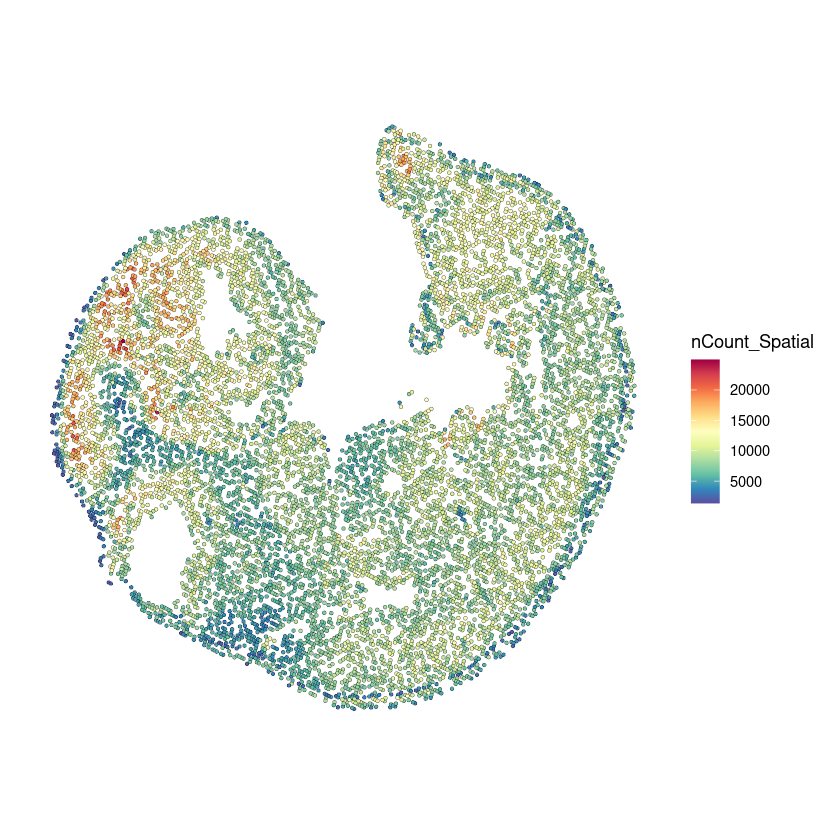

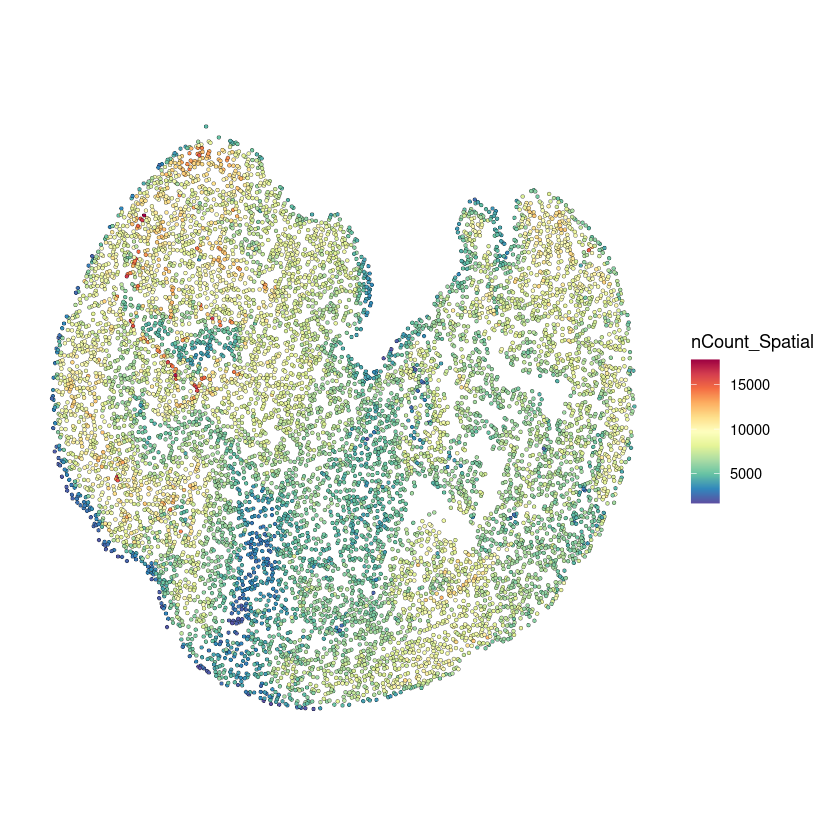

In [7]:
coord.df.1 <- data.frame(x = adata1$obsm$spatial[, 1], y = adata1$obsm$spatial[, 2], stringsAsFactors = FALSE)
rownames(coord.df.1) <- Cells(slide.seq.1)
slide.seq.1@images$image <- new(
    Class = "SlideSeq", # can not change class name
    assay = "Spatial",
    key = "image_",
    coordinates = coord.df.1
  )

coord.df.2 <- data.frame(x = adata2$obsm$spatial[, 1], y = adata2$obsm$spatial[, 2], stringsAsFactors = FALSE)
rownames(coord.df.2) <- Cells(slide.seq.2)
slide.seq.2@images$image <- new(
    Class = "SlideSeq", # can not change class name
    assay = "Spatial",
    key = "image_",
    coordinates = coord.df.2
  )
SpatialFeaturePlot(slide.seq.1, features = "nCount_Spatial") + theme(legend.position = "right")
SpatialFeaturePlot(slide.seq.2, features = "nCount_Spatial") + theme(legend.position = "right")


In [8]:
slide.seq.1@meta.data["batch"] <- "a1"
slide.seq.2@meta.data["batch"] <- "a2"
seu_list <- list(slide.seq.1, slide.seq.2)
seu_list <- lapply(X = seu_list, FUN = function(x) {
    x <- NormalizeData(x) # has been normalized
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2500)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = seu_list)

In [9]:
seu.anchors <- FindIntegrationAnchors(object.list = seu_list, anchor.features = features, verbose = FALSE)
seu_combined <- IntegrateData(anchorset = seu.anchors, verbose = FALSE)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [12]:
DefaultAssay(seu_combined) <- "integrated"
seu_combined <- ScaleData(seu_combined, verbose = FALSE)
seu_combined <- RunPCA(seu_combined, npcs = 50, verbose = FALSE)

In [13]:
embd1 <- seu_combined@reductions$pca@cell.embeddings[1:dim(slide.seq.1)[2], ]
embd2 <- seu_combined@reductions$pca@cell.embeddings[-c(1:dim(slide.seq.1)[2]), ]
fwrite(embd1, sep = ",", file = "./seurat_embd0.csv")
fwrite(embd2, sep = ",", file = "./seurat_embd1.csv")

x being coerced from class: matrix to data.table

x being coerced from class: matrix to data.table

